In [52]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
df = pd.read_csv('/content/buzzfeed_headlines.csv')
df.sample(5)

,content,description,title
547,Get all the best Tasty recipes in your inbox! ...,Thankful I wasn't there!View Entire Post ›,14 Thanksgiving Fails I Wouldn't Even Wish Upo...
353,Hallow-queens and kings of fashion.,Hallow-queens and kings of fashion. View Entir...,"TBH, These 30 Red Carpet Looks Would Make Pret..."
499,Sign up to the BuzzFeed Quizzes Newsletter - B...,It's giving nail polish tbh...View Entire Post ›,"If You Stan Harry Styles, Choose Some Pets And..."
173,Frank Ockenfels / ABC via Getty Images\r\nThos...,Baskin participated in a candid Reddit AMA and...,"Carole Baskin Of ""Tiger King"" Revealed What Sh..."
241,"Note: In case you didn't know, a multilevel ma...","""Sorry your grandma died... Please buy my prod...","16 Times The ""Boss Babes"" In MLMs Took Things ..."


In [54]:
df.drop(['content', 'description'], axis=1, inplace=True)

In [55]:
!pip install langdetect

In [56]:
from langdetect import detect

In [57]:
def detect_lang(txt):
    try:
        return detect(txt)
    except:
        return np.nan
    
df['language'] = df.title.apply(detect_lang)
df = df[df.language == "en"]
df = df.drop('language', axis=1)

In [58]:
df.isna().sum()

title    0
dtype: int64

In [59]:
df.sample(12)

,title
402,"What Questions Does ""Squid Game"" Season Two Ne..."
657,"Let's Rank The Wildest Moments On ""You"" Season..."
60,These 13 Rules Are Considered Part Of The Unsp...
571,"Chances Are, Your Birth Control Comes With A L..."
398,38 Shocking Photos Of Iconic Places Now Vs. If...
600,"Two Months Ago, I Switched One Thing In My Ski..."
135,Here's A Recap Of The Latest Celeb News — The ...
144,Prince Harry And Meghan Markle Made A Statemen...
456,Zendaya And Tom Holland's Adorable Instagram I...
412,Former Victoria's Secret Angel Erin Heatherton...


In [60]:
# Not going to remove stop words at first to see if the models
# can pick up proper syntax of everything and spit out a 
# headline that looks really similar to real ones rather than 
# headlines with no stop words

# also going to leave the tokenization until later when 
# we do it through TF/Keras
import string

def preprocess(df):
  # stop_words = stopwords.words('english')
  df['title'] = df['title'].str.lower()
  df['title'] = df['title'].str.replace('[^a-zA-Z0-9]', ' ') # replace non-alphanumeric characters with spaces
  df['title'] = df['title'].str.replace('\s+', ' ') # replace multiple spaces with a single space
  df['title'] = df['title'].str.strip() # remove leading and trailing spaces
  # df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

  return df

df = preprocess(df)
df.sample(12)

,title
56,23 product before and after photos you will pr...
122,i wish i d always known these 19 empowering fa...
369,these 18 posts are straight out of an alternat...
559,adele recalled feeling ashamed during her divo...
584,14 people told us how having no student loan d...
47,lena dunham explained why a girls reboot isn t...
172,i simply don t understand why more people aren...
478,the mentalist actor simon baker has reportedly...
518,whoopi goldberg refused to wear fake jewels in...
649,mindy kaling dressed up as issa rae elle woods...


In [61]:
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils as ku
from tensorflow.random import set_seed
from numpy.random import seed

set_seed(2022)
seed(1)

In [62]:
corpus = [title for title in df['title']]
corpus[:10]

['16 wholesome details from tv and movies that show they were quite literally made with love',
 'jacob elordi has been living the dream filming passionate love scenes with sydney sweeney on euphoria and he knows it',
 'people are sharing things that helped them get a better work life balance and it s so refreshing',
 '7 actors who were considered too ugly for a role and 8 who weren t ugly enough',
 'brian cox says he turned down a role in pirates of the caribbean',
 'eat at this dessert buffet like a toddler at a birthday party and i ll tell you which bsc character you remind me of',
 'directors must really love these 17 pairs of actors together since they keep getting cast as costars',
 'all of the major pop culture happenings this week from celebrity tributes to new trailers',
 'aussies are sharing how their experiences overseas have changed their view on australia and the responses are fascinating',
 'telling you not to discuss your pay with coworkers and 18 other red flags in the w

In [63]:
# Generating Sequence of N-gram Tokens

tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
  # tokenization
  tokenizer.fit_on_texts(corpus)
  total_words = len(tokenizer.word_index) + 1

  # convert data to sequence of tokens
  input_sequences = []
  for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
      n_gram_sequence = token_list[:i+1]
      input_sequences.append(n_gram_sequence)
  return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

[[116, 298],
 [116, 298, 179],
 [116, 298, 179, 24],
 [116, 298, 179, 24, 85],
 [116, 298, 179, 24, 85, 2],
 [116, 298, 179, 24, 85, 2, 117],
 [116, 298, 179, 24, 85, 2, 117, 7],
 [116, 298, 179, 24, 85, 2, 117, 7, 107],
 [116, 298, 179, 24, 85, 2, 117, 7, 107, 17],
 [116, 298, 179, 24, 85, 2, 117, 7, 107, 17, 48]]

In [64]:
# Padding the Sequences and get predictors & targets/labels

def generate_padded_sequences(input_sequences):
  max_sequence_len = max([len(x) for x in input_sequences])
  input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
  predictors, label = input_sequences[:,:-1], input_sequences[:, -1]
  label = ku.to_categorical(label, num_classes=total_words)
  return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [65]:
from tensorflow.python.keras.utils.data_utils import Sequence
# LSTM model for Text Generation

def create_model(max_sequence_len, total_words):
  input_len = max_sequence_len - 1
  model = Sequential()

  # Input Embedding Layer
  model.add(Embedding(total_words, 10, input_length=input_len))

  # Add a Hidden Layer - LSTM Layer
  model.add(LSTM(100))
  model.add(Dropout(0.2))

  # Add Output Layer
  model.add(Dense(total_words, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam')
  return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 29, 10)            26930     
                                                                 
 lstm_2 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 2693)              271993    
                                                                 
Total params: 343,323
Trainable params: 343,323
Non-trainable params: 0
_________________________________________________________________


In [66]:
# training our model
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
307/307 [==============================] - 5s 9ms/step - loss: 7.0417
Epoch 2/100
307/307 [==============================] - 3s 9ms/step - loss: 6.6196
Epoch 3/100
307/307 [==============================] - 3s 9ms/step - loss: 6.5013
Epoch 4/100
307/307 [==============================] - 3s 9ms/step - loss: 6.3849
Epoch 5/100
307/307 [==============================] - 3s 9ms/step - loss: 6.2468
Epoch 6/100
307/307 [==============================] - 3s 10ms/step - loss: 6.1109
Epoch 7/100
307/307 [==============================] - 3s 9ms/step - loss: 5.9717
Epoch 8/100
307/307 [==============================] - 3s 8ms/step - loss: 5.8417
Epoch 9/100
307/307 [==============================] - 3s 9ms/step - loss: 5.7174
Epoch 10/100
307/307 [==============================] - 3s 9ms/step - loss: 5.5914
Epoch 11/100
307/307 [==============================] - 3s 9ms/step - loss: 5.4702
Epoch 12/100
307/307 [==============================] - 3s 8ms/step - loss: 5.3523
Epoch 13/100

In [67]:
def generate_text(seed_text, next_words, model, max_sequence_len):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list, verbose=0))

    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += " " + output_word

  return seed_text.title()

In [68]:
print(generate_text("21 things", 6, model, max_sequence_len))
print(generate_text("you wouldnt believe", 8, model, max_sequence_len))
print(generate_text("hollywood", 5, model, max_sequence_len))
print(generate_text("coming this year", 8, model, max_sequence_len))
print(generate_text("celebrities", 6, model, max_sequence_len))

21 Things Publix Workers Absolutely Hate
You Wouldnt Believe At A Buffet Of The
Hollywood Of The Best Queer Characters
Coming This Year And I Ll Not Whether You Re Trying
Celebrities Are Sharing The Toughest Lesson They


In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

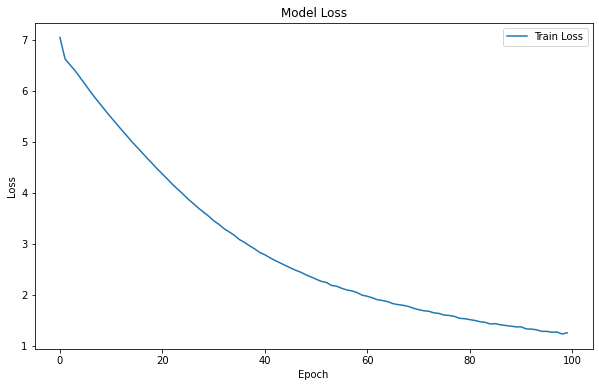

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show();